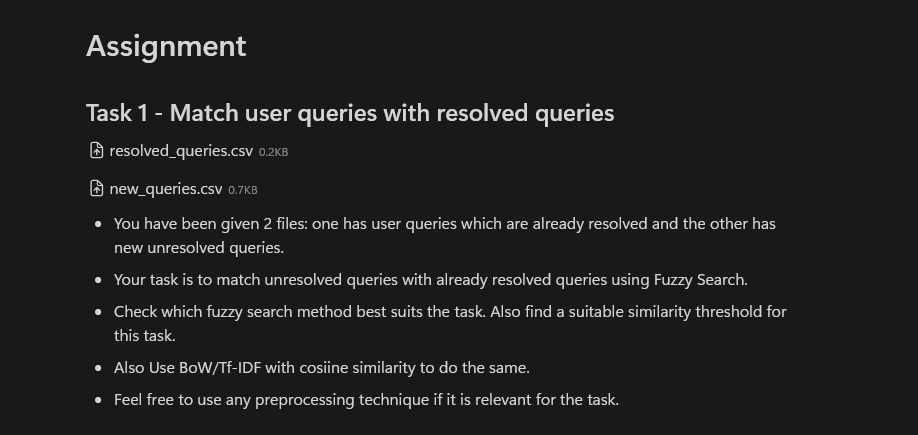

In [1]:
!pip install thefuzz

  Obtaining dependency information for thefuzz from https://files.pythonhosted.org/packages/82/4f/1695e70ceb3604f19eda9908e289c687ea81c4fecef4d90a9d1d0f2f7ae9/thefuzz-0.22.1-py3-none-any.whl.metadata
  Obtaining dependency information for rapidfuzz<4.0.0,>=3.0.0 from https://files.pythonhosted.org/packages/f3/96/c783107296403cf50acde118596b07aa1af4b0287ac4600b38b0673b1fd7/rapidfuzz-3.14.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.7 MB 3.3 MB/s eta 0:00:01
   ----------------------------------- ---- 1.5/1.7 MB 23.3 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 17.6 MB/s eta 0:00:00


In [1]:
import pandas as pd
from thefuzz import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np

# Load the datasets
new_queries = pd.read_csv(r'C:\Users\laava\Desktop\sem 7\NLP\new_queries.csv')
resolved_queries = pd.read_csv(r'C:\Users\laava\Desktop\sem 7\NLP\resolved_queries.csv')

# --- 1. Preprocessing Function ---
def preprocess_text(text):
    text = str(text).lower()  # Lowercasing
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    # A more comprehensive preprocessing pipeline might include stop word removal and stemming/lemmatization
    return text

# Apply preprocessing
new_queries['Clean_Query'] = new_queries['Variation_Query'].apply(preprocess_text)
resolved_queries['Clean_Query'] = resolved_queries['Pre_Resolved_Query'].apply(preprocess_text)

# --- 2. Fuzzy Search Matching ---

print("### Matching using Fuzzy Search (token_set_ratio) ###")
print("-" * 50)
fuzzy_matches = []
# Set a similarity threshold
FUZZY_THRESHOLD = 85

for new_q_idx, new_row in new_queries.iterrows():
    best_match_score = -1
    best_match_id = None
    
    for resolved_q_idx, resolved_row in resolved_queries.iterrows():
        score = fuzz.token_set_ratio(new_row['Clean_Query'], resolved_row['Clean_Query'])
        
        if score > best_match_score:
            best_match_score = score
            best_match_id = resolved_row['Query_ID']
    
    # Check if the best match is above the threshold
    if best_match_score >= FUZZY_THRESHOLD:
        fuzzy_matches.append({
            'New_Query': new_row['Variation_Query'],
            'Best_Match_ID': best_match_id,
            'Similarity_Score': best_match_score
        })
    else:
        fuzzy_matches.append({
            'New_Query': new_row['Variation_Query'],
            'Best_Match_ID': 'No Good Match Found',
            'Similarity_Score': best_match_score
        })

fuzzy_results_df = pd.DataFrame(fuzzy_matches)
print(fuzzy_results_df.to_string())

print("\n" + "="*50 + "\n")

# --- 3. TF-IDF and Cosine Similarity Matching ---

print("### Matching using TF-IDF and Cosine Similarity ###")
print("-" * 50)

# Create a TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'\b\w+\b')

# Fit the vectorizer on the resolved queries and transform them
tfidf_resolved_queries = vectorizer.fit_transform(resolved_queries['Clean_Query'])

# Transform the new queries
tfidf_new_queries = vectorizer.transform(new_queries['Clean_Query'])

# Calculate cosine similarity between each new query and all resolved queries
cosine_sim_matrix = cosine_similarity(tfidf_new_queries, tfidf_resolved_queries)

tfidf_matches = []
# Set a similarity threshold
COSINE_THRESHOLD = 0.65

for i in range(len(new_queries)):
    best_match_score = -1
    best_match_id = None
    
    # Find the index of the highest similarity score for the current new query
    best_match_index = np.argmax(cosine_sim_matrix[i])
    best_match_score = cosine_sim_matrix[i][best_match_index]
    best_match_id = resolved_queries.iloc[best_match_index]['Query_ID']

    if best_match_score >= COSINE_THRESHOLD:
        tfidf_matches.append({
            'New_Query': new_queries.iloc[i]['Variation_Query'],
            'Best_Match_ID': best_match_id,
            'Similarity_Score': best_match_score
        })
    else:
        tfidf_matches.append({
            'New_Query': new_queries.iloc[i]['Variation_Query'],
            'Best_Match_ID': 'No Good Match Found',
            'Similarity_Score': best_match_score
        })

tfidf_results_df = pd.DataFrame(tfidf_matches)
print(tfidf_results_df.to_string())

### Matching using Fuzzy Search (token_set_ratio) ###
--------------------------------------------------
                                    New_Query        Best_Match_ID  Similarity_Score
0            Unabel to conect to the internet                    1                95
1                   Can’t connect to internet                    1                88
2                         Intenet not working  No Good Match Found                49
3                Payment failed while chekout  No Good Match Found                83
4   Payment did not go through during chckout  No Good Match Found                70
5                  Payment issue at check out  No Good Match Found                57
6    Application crashes when opening setings                    3                88
7            App crash when going to settings                    3                86
8            Settings cause the app to chrash  No Good Match Found                65
9               Forgot passwrd and cant reset

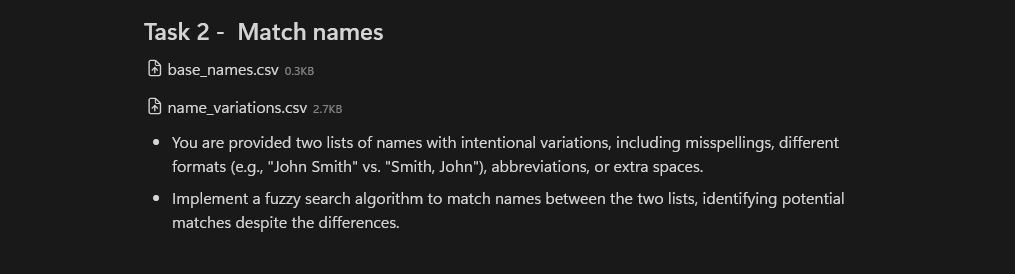

In [2]:
!pip install fuzzywuzzy[speedup] pandas

  Obtaining dependency information for fuzzywuzzy[speedup] from https://files.pythonhosted.org/packages/43/ff/74f23998ad2f93b945c0309f825be92e04e0348e062026998b5eefef4c33/fuzzywuzzy-0.18.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for python-levenshtein>=0.12 from https://files.pythonhosted.org/packages/2a/95/8c8fd923b0a702388da4f9e0368f490d123cc5224279e6a083984304a15e/python_levenshtein-0.27.1-py3-none-any.whl.metadata
  Obtaining dependency information for Levenshtein==0.27.1 from https://files.pythonhosted.org/packages/aa/ae/444d6e8ba9a35379a56926716f18bb2e77c6cf69e5324521fbe6885f14f6/levenshtein-0.27.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/100.4 kB ? eta -:--:--
   ------------------------------------ --- 92.2/100.4 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 100.4/100.4 kB 1.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import re
from io import StringIO

def normalize_name(name):
    """
    Normalizes a name string by converting to lowercase, removing special
    characters and extra spaces, and sorting the tokens.
    """
    # Convert to lowercase
    name = str(name).lower()
    # Remove special characters and numbers, replace with space
    name = re.sub(r'[^a-zA-Z\s]', '', name)
    # Remove extra whitespace
    name = re.sub(r'\s+', ' ', name).strip()
    # Handle common name reordering by sorting tokens
    tokens = name.split()
    tokens.sort()
    return " ".join(tokens)

def fuzzy_match_names(variations_df, base_names_df, score_cutoff=85):
    """
    Performs fuzzy matching between two dataframes of names.
    
    Args:
        variations_df (pd.DataFrame): DataFrame with 'Variation' column.
        base_names_df (pd.DataFrame): DataFrame with 'Base_Name' column.
        score_cutoff (int): The minimum similarity score to be considered a match.

    Returns:
        pd.DataFrame: A DataFrame with the variation, its best match, and the score.
    """
    base_names_list = base_names_df['Base_Name'].tolist()
    
    results = []
    
    for _, row in variations_df.iterrows():
        variation = row['Variation']
        
        # Use fuzzywuzzy's process.extractOne to find the best match
        # The scorer is set to token_sort_ratio to handle word order variations
        match = process.extractOne(
            variation, 
            base_names_list, 
            scorer=fuzz.token_sort_ratio,
            processor=normalize_name
        )
        
        # Check if a match was found and if it meets the cutoff score
        if match and match[1] >= score_cutoff:
            best_match = match[0]
            score = match[1]
            results.append({
                'Variation': variation,
                'Best_Match': best_match,
                'Similarity_Score': score
            })
        else:
            results.append({
                'Variation': variation,
                'Best_Match': 'No Match Found',
                'Similarity_Score': 0
            })
            
    return pd.DataFrame(results)

# --- Main Script ---

# Create DataFrames from the provided CSV content
variations_data = """Variation,Matches_With_Base_Name
Thomas  King,Thomas King
ThomasKing,Thomas King
Maria Garcia,Maria Garcia
MaryLewis,Mary Lewis
Nancy W.,Nancy Wright
Dani3l Scott,Daniel Scott
JOHN  smith,John Smith
linda johnson,Linda Johnson
N@ncy Wright,Nancy Wright
William Davis,William Davis
Susan  Clark,Susan Clark
SusanClark,Susan Clark
Jennifer- Brown,Jennifer Brown
Michael O'Connor,Michael O'Connor
Rodriguez James,James Rodriguez
Elizabeth Wil5on,Elizabeth Wilson
Hill Sandra,Sandra Hill
THOMAS KING,Thomas King
Christoph3r Green,Christopher Green
Wi11iam Davis,William Davis
linda johnson,Linda Johnson
John tihSm,John Smith
Nancy Wright,Nancy Wright
Robert L.,Robert Lee
Christopher Green,Christopher Green
Thomas King,Thomas King
Rob3rt Lee,Robert Lee
Kar3n Young,Karen Young
DAVID  martinez,David Martinez
N@ncy Wright,Nancy Wright
Elizab3th Wilson,Elizabeth Wilson
Maria  Garcia,Maria Garcia
Robert  Lee,Robert Lee
Nancy Wright,Nancy Wright
Maria G.,Maria Garcia
S@ndr@ Hill,Sandra Hill
Mary Lew,Mary Lewis
Jessic@ Adams,Jessica Adams
William  Davis,William Davis
Maria  Garcia,Maria Garcia
Jennifer Brown,Jennifer Brown
jennifer brown,Jennifer Brown
Mary  Lewis,Mary Lewis
Susan Clark,Susan Clark
Michael  O'Connor,Michael O'Connor
Clark Susan,Susan Clark
Sandra 
Hill.,Sandra Hill
Mich@el O'Connor,Michael O'Connor
Christopher  Green,Christopher Green
Daniel Scott,Daniel Scott
J. Smith,John Smith
Jessica  Adams,Jessica Adams
Mary Lew,Mary Lewis
Elizab3th Wilson,Elizabeth Wilson
sandra hill,Sandra Hill
linda johnson,Linda Johnson
Adams Jessica,Jessica Adams
Daniel  Scott,Daniel Scott
PAUL ALLEN,Paul Allen
Paul Allen.,Paul Allen
Susan Clark,Susan Clark
JamesRodriguez,James Rodriguez
Thomas King,Thomas King
Linda  Johnson,Linda Johnson
elizabeth wilson,Elizabeth Wilson
Karen Young,Karen Young
MICHAEL O'CONNOR,Michael O'Connor
Linda Johnson,Linda Johnson
Maria  Garcia,Maria Garcia
Sandra Hil,Sandra Hill
J. Adams,Jessica Adams
Lewis Mary,Mary Lewis
Christopher  Green,Christopher Green
Rodriguez James,James Rodriguez
christopher green,Christopher Green
William  Davis,William Davis
James- Rodriguez,James Rodriguez
Robert L.,Robert Lee
Rob Lee,Robert Lee
Kar Young,Karen Young
elizabeth wilson,Elizabeth Wilson
David M.,David Martinez
Daniel  Scott,Daniel Scott
D@vid Martinez,David Martinez
Jam Rodriguez,James Rodriguez
Karen  Young,Karen Young
WilliamDavis,William Davis
John- Smith,John Smith
John  Smith,John Smith
David Martinez,David Martinez
Young Karen,Karen Young
Jessica Adams,Jessica Adams
Michael 
 O'Connor,Michael O'Connor
paul allen,Paul Allen
JENNIFER  brown,Jennifer Brown
Jennifer- Brown,Jennifer Brown
Daniel- Scott,Daniel Scott
David M.,David Martinez
Paul Allen.,Paul Allen
Paul  Allen,Paul Allen"""
variations_df = pd.read_csv(StringIO(variations_data))

base_names_data = """Base_Name_ID,Base_Name
1,John Smith
2,Jennifer Brown
3,Michael O'Connor
4,Maria Garcia
5,Robert Lee
6,Linda Johnson
7,William Davis
8,Elizabeth Wilson
9,David Martinez
10,Susan Clark
11,James Rodriguez
12,Mary Lewis
13,Paul Allen
14,Karen Young
15,Thomas King
16,Nancy Wright
17,Daniel Scott
18,Sandra Hill
19,Christopher Green
20,Jessica Adams"""
base_names_df = pd.read_csv(StringIO(base_names_data))

# Run the fuzzy matching algorithm
matches = fuzzy_match_names(variations_df, base_names_df)

# Display the results
print(matches)

           Variation      Best_Match  Similarity_Score
0       Thomas  King     Thomas King               100
1         ThomasKing  No Match Found                 0
2       Maria Garcia    Maria Garcia               100
3          MaryLewis  No Match Found                 0
4           Nancy W.  No Match Found                 0
..               ...             ...               ...
97   Jennifer- Brown  Jennifer Brown               100
98     Daniel- Scott    Daniel Scott               100
99          David M.  No Match Found                 0
100      Paul Allen.      Paul Allen               100
101      Paul  Allen      Paul Allen               100

[102 rows x 3 columns]
